<a href="https://colab.research.google.com/github/rob-netzke/binding_energies/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import numpy as np 

In [ ]:
%cd drive/My\ Drive/Binding\ Energies

/content/drive/My Drive/Binding Energies


In [ ]:
!ls

binding_energy_nn.png  data  data.ipynb  model.ipynb  results


In [ ]:
tf.random.set_seed(235)

In [ ]:
data = pd.read_csv("./data/formatted_table.csv")

In [ ]:
data.head()

,Unnamed: 0,element,binding_energy,nuetron_number,element_name,proton_number
0,0,1H,0.0000,1,H,1
1,1,20Mg,134.4703,20,Mg,12
2,2,34S,291.8432,34,S,16
3,3,47Ar,391.1855,47,Ar,18
4,4,2H,2.2245,2,H,1


In [ ]:
def ap_term(n,z,a):
  if (n % 2 == 0) & (z % 2 == 0): return a ** (-0.5)
  elif (a % 2 == 1): return 0
  else: return -(a ** (-0.5))

In [ ]:
ap_filter = np.vectorize(ap_term)

In [ ]:
def preprocess_df(df, train=True):
  X = pd.DataFrame()
  X['N'] = df['nuetron_number']
  X['Z'] = df['proton_number']
  X['A'] = X['N'] + X['Z']
  X['ST'] = X['A'] ** (2/3)
  X['CT'] = (X['Z'] * (X['Z'] - 1)) / (X['A'] ** (1/3))
  X['AT'] = ((X['N'] - X['Z']) ** 2) / X['A']

  X['PE'] = np.where(np.logical_and(X['Z'] % 2 == 0 , X['N'] % 2 == 0), 
                   X['A'] ** (-0.5), -(X['A'] ** (-0.5)))
  X['PE'] = np.where(X['A'] % 2 == 1, 0, X['PE'])

  # X['PE'] = ap_filter(X['N'], X['Z'], X['A'])
  y = df['binding_energy']
  if train:
    return X.drop(['N','Z'], axis=1), y
  else:
    X['BE'] = df['binding_energy']
    return X.sort_values(by='A')

In [ ]:
X, y = preprocess_df(data)

In [ ]:
X.head()

,A,ST,CT,AT,PE
0,2,1.587401,0.000000,0.000000,-0.707107
1,32,10.079368,41.577395,2.000000,0.176777
2,50,13.572088,65.146023,6.480000,0.141421
3,65,16.166236,76.105663,12.938462,0.000000
4,3,2.080084,0.000000,0.333333,0.000000


In [ ]:
# y = y / 100

In [ ]:
y

0          0.0000
1        134.4703
2        291.8432
3        391.1855
4          2.2245
          ...    
1030    1013.7687
1031    1026.8621
1032     926.0836
1033     976.2169
1034    1014.8602
Name: binding_energy, Length: 1035, dtype: float64

#### model

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(5,)))
model.add(layers.Dense(10, activation='relu', name='L2'))
model.add(layers.Dense(10, activation='relu', name='L3'))
model.add(layers.Dense(1, activation='relu', name='Out'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_3 (ModuleWra  (None, 10)               60        
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 10)               110       
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 1)                11        
 pper)                                                           
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X, y, epochs=1000)

Epoch 1/1000
33/33 [==============================] - 0s 2ms/step - loss: 373147.9062
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 270339.9688
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 175020.9844
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 96486.0469
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 40665.2695
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 13068.1221
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 4869.7632
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 3666.5659
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 3557.5527
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 3534.2043
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 3502.8015
Epoch 12/1000
33/33 [==============================] - 0s 2ms/ste

In [ ]:
model.predict(X[:4]) 

array([[  0.     ],
       [144.7639 ],
       [290.38736],
       [391.28757]], dtype=float32)

In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")

version = '001'

name = version+'_'+current_time

In [ ]:
model.save(f'./results/models/{name}')

#### analysis of model performance

In [ ]:
X = preprocess_df(data, train=False)

In [ ]:
X.head()

,N,Z,A,ST,CT,AT,PE,BE
0,1,1,2,1.587401,0.000000,0.000000,-0.707107,0.0000
4,2,1,3,2.080084,0.000000,0.333333,0.000000,2.2245
8,3,1,4,2.519842,0.000000,1.000000,-0.500000,8.4820
12,3,2,5,2.924018,1.169607,0.200000,0.000000,7.7186
16,4,2,6,3.301927,1.100642,0.666667,0.408248,28.2970


In [ ]:
y_pred = model.predict(X.drop(['N','Z','BE'],axis=1))

In [ ]:
y_pred

array([[   0.       ],
       [   0.       ],
       [   3.1067147],
       ...,
       [1029.8469   ],
       [1032.6399   ],
       [1034.2223   ]], dtype=float32)

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,14)

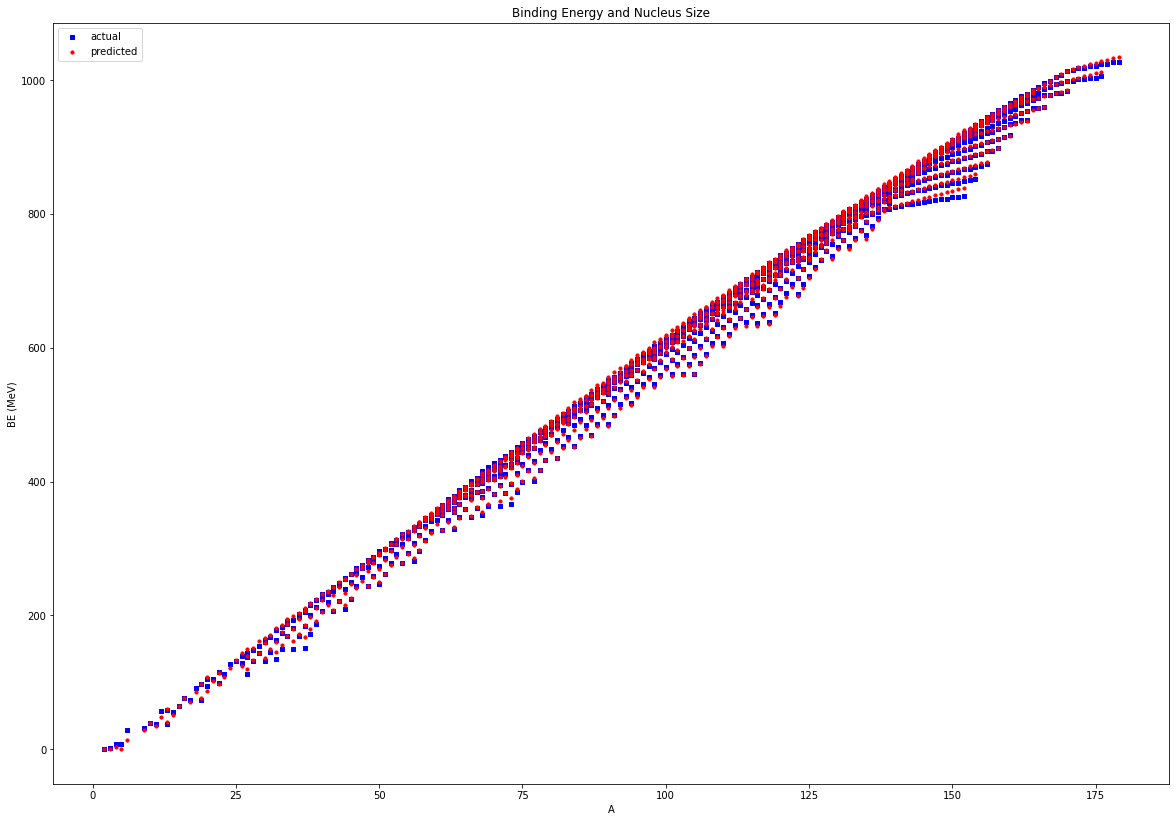

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X['A'], X['BE'], s=10, c='b', marker="s", label='actual')
ax1.scatter(X['A'], y_pred, s=10, c='r', marker="o", label='predicted')
plt.title('Binding Energy and Nucleus Size')
plt.ylabel('BE (MeV)')
plt.xlabel('A')
plt.legend(loc='upper left');
plt.show()

Text(0.5, 0, 'Training Epoch')

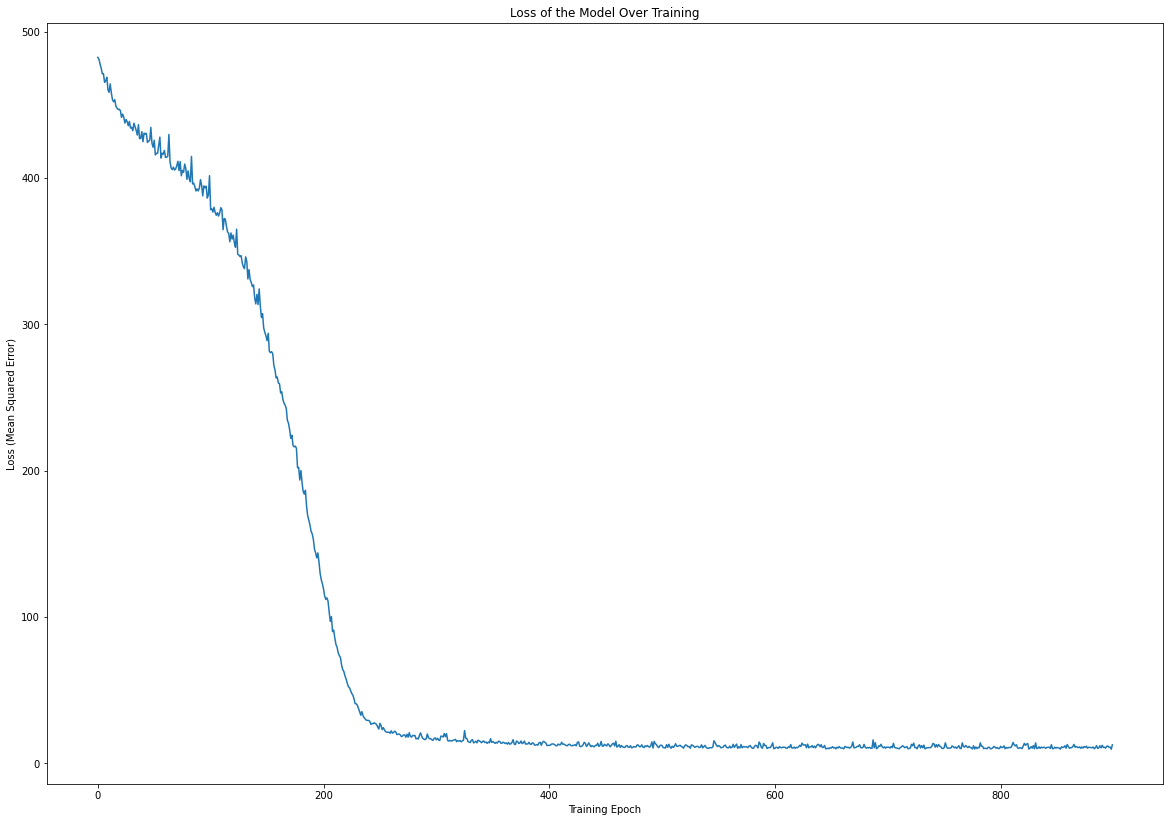

In [ ]:
plt.plot(history.history['loss'][100:])
plt.title('Loss of the Model Over Training')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Training Epoch')

In [ ]:
def unstack(a, axis=0):
    return np.moveaxis(a, axis, 0)

In [ ]:
resid = np.array(X['BE']) - unstack(y_pred,axis=1)[0]

In [ ]:
resid

array([ 0.        ,  2.2245    ,  5.37528527, ..., -5.26792383,
       -5.84939258, -7.36019004])

In [ ]:
unstack(y_pred,axis=1)[0]

array([   0.       ,    0.       ,    3.1067147, ..., 1029.8469   ,
       1032.6399   , 1034.2223   ], dtype=float32)

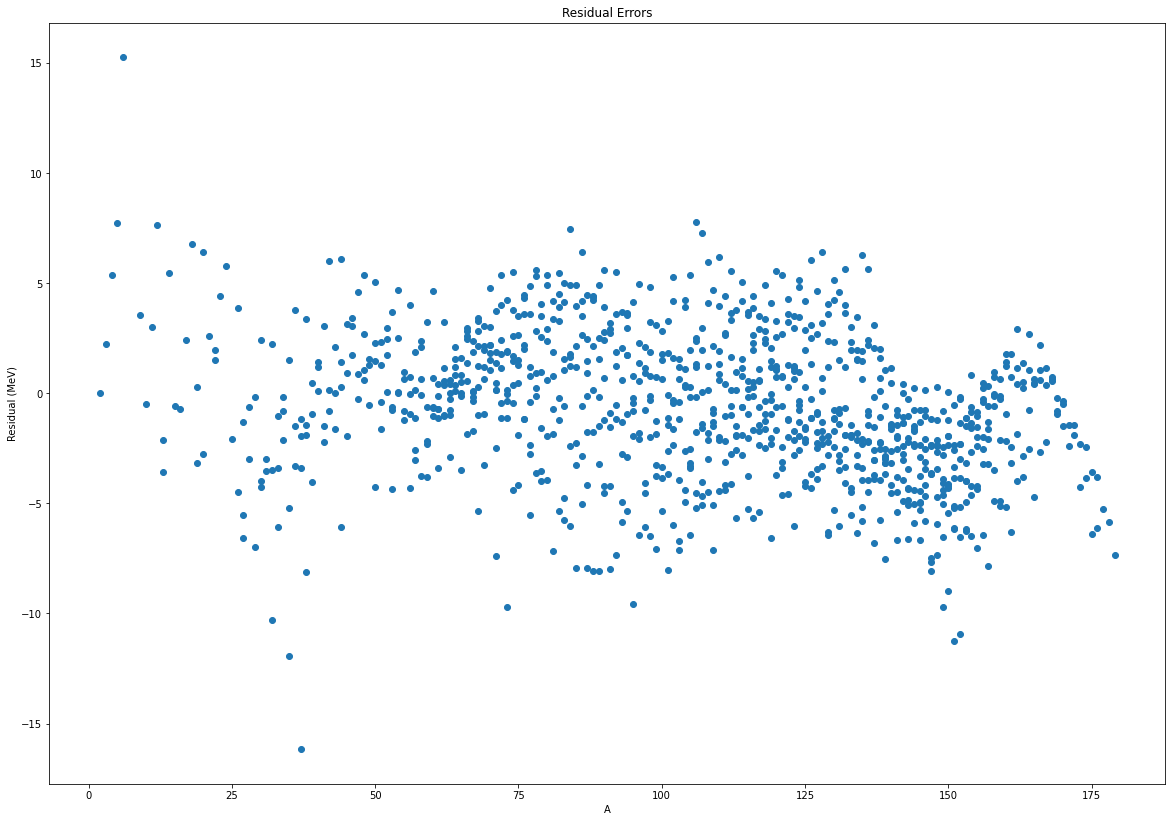

In [ ]:
plt.title('Residual Errors')
plt.ylabel('Residual (MeV)')
plt.xlabel('A')
plt.scatter(X['A'], resid)


In [ ]:
m = min(resid)
print(list(resid).index(m))

56


In [ ]:
X.iloc[56]

N      23.000000
Z      14.000000
A      37.000000
ST     11.103702
CT     54.618212
AT      2.189189
PE      0.000000
BE    151.159800
Name: 81, dtype: float64